In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [2]:
!pip install py2neo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 6.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from datasets import Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import TrainingArguments, Trainer
import evaluate
from py2neo import Graph

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


PreProcessing

In [5]:
df_airline = pd.read_table('/content/drive/MyDrive/RSBP/BA_AirlineReviews.csv', sep=None, engine="python")
df_airline.head()

,Unnamed: 0,OverallRating,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity
0,0,1.0,"""Service level far worse then Ryanair""",L Keele,19th November 2023,True,4 Hours before takeoff we received a Mail stat...,Couple Leisure,Economy Class,London to Stuttgart,November 2023,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN
1,1,3.0,"""do not upgrade members based on status""",Austin Jones,19th November 2023,True,I recently had a delay on British Airways from...,Business,Economy Class,Brussels to London,November 2023,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0
2,2,8.0,"""Flight was smooth and quick""",M A Collie,16th November 2023,False,"Boarded on time, but it took ages to get to th...",Couple Leisure,Business Class,London Heathrow to Dublin,November 2023,3.0,3.0,4.0,3.0,yes,A320,4.0,NaN,NaN
3,3,1.0,"""Absolutely hopeless airline""",Nigel Dean,16th November 2023,True,"5 days before the flight, we were advised by B...",Couple Leisure,Economy Class,London to Dublin,December 2022,3.0,3.0,1.0,1.0,no,NaN,NaN,NaN,NaN
4,4,1.0,"""Customer Service is non existent""",Gaylynne Simpson,14th November 2023,False,"We traveled to Lisbon for our dream vacation, ...",Couple Leisure,Economy Class,London to Lisbon,November 2023,1.0,1.0,1.0,1.0,no,NaN,1.0,1.0,1.0


In [6]:
df_airline = df_airline.drop(columns=["Unnamed: 0"])

In [7]:
df_airline[df_airline.duplicated(keep=False)]

,OverallRating,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity
3092,4.0,British Airways customer review,Angie Kirkpatrick,17th March 2015,False,London to Budapest and back in Club class. Fir...,NaN,Business Class,NaN,NaN,1.0,4.0,NaN,2.0,no,NaN,3.0,1.0,NaN
3100,4.0,British Airways customer review,Angie Kirkpatrick,17th March 2015,False,London to Budapest and back in Club class. Fir...,NaN,Business Class,NaN,NaN,1.0,4.0,NaN,2.0,no,NaN,3.0,1.0,NaN
3199,10.0,British Airways customer review,Alan Wan,11th January 2015,False,LHR-SFO. I paid premium economy but upgrade wi...,NaN,Business Class,NaN,NaN,5.0,5.0,NaN,5.0,yes,NaN,3.0,3.0,NaN
3202,10.0,British Airways customer review,Alan Wan,11th January 2015,False,LHR-SFO. I paid premium economy but upgrade wi...,NaN,Business Class,NaN,NaN,5.0,5.0,NaN,5.0,yes,NaN,3.0,3.0,NaN
3397,7.0,British Airways customer review,D Taylor,1st October 2014,False,LHR to Amman Jordan Airbus 321. Outward flight...,NaN,Premium Economy,NaN,NaN,3.0,4.0,NaN,3.0,yes,NaN,4.0,2.0,NaN
3398,9.0,British Airways customer review,A Cork,1st October 2014,False,LHR-FCO. Flew out Club Europe courtesy of a re...,NaN,Business Class,NaN,NaN,5.0,5.0,NaN,5.0,yes,NaN,4.0,1.0,NaN
3399,10.0,British Airways customer review,Ash David,1st October 2014,False,Flew BA055 LHR to JNB on the new A380. What an...,NaN,Business Class,NaN,NaN,4.0,5.0,NaN,4.0,yes,NaN,5.0,5.0,NaN
3400,7.0,British Airways customer review,D Taylor,1st October 2014,False,LHR to Amman Jordan Airbus 321. Outward flight...,NaN,Premium Economy,NaN,NaN,3.0,4.0,NaN,3.0,yes,NaN,4.0,2.0,NaN
3401,9.0,British Airways customer review,A Cork,1st October 2014,False,LHR-FCO. Flew out Club Europe courtesy of a re...,NaN,Business Class,NaN,NaN,5.0,5.0,NaN,5.0,yes,NaN,4.0,1.0,NaN
3402,10.0,British Airways customer review,Ash David,1st October 2014,False,Flew BA055 LHR to JNB on the new A380. What an...,NaN,Business Class,NaN,NaN,4.0,5.0,NaN,4.0,yes,NaN,5.0,5.0,NaN


In [8]:
df_airline = df_airline.drop_duplicates()
df_airline = df_airline.reset_index(drop=True)
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OverallRating          3689 non-null   float64
 1   ReviewHeader           3694 non-null   object 
 2   Name                   3694 non-null   object 
 3   Datetime               3694 non-null   object 
 4   VerifiedReview         3694 non-null   bool   
 5   ReviewBody             3694 non-null   object 
 6   TypeOfTraveller        2930 non-null   object 
 7   SeatType               3692 non-null   object 
 8   Route                  2926 non-null   object 
 9   DateFlown              2923 non-null   object 
 10  SeatComfort            3578 non-null   float64
 11  CabinStaffService      3567 non-null   float64
 12  GroundService          2855 non-null   float64
 13  ValueForMoney          3693 non-null   float64
 14  Recommended            3694 non-null   object 
 15  Airc

In [9]:
df_airline.isnull().sum()

,0
OverallRating,5
ReviewHeader,0
Name,0
Datetime,0
VerifiedReview,0
ReviewBody,0
TypeOfTraveller,764
SeatType,2
Route,768
DateFlown,771


In [10]:
df_airline = df_airline.dropna(subset=['OverallRating', 'SeatType', 'ValueForMoney'])
df_airline = df_airline.reset_index(drop=True)

In [11]:
df_airline.isnull().sum()

,0
OverallRating,0
ReviewHeader,0
Name,0
Datetime,0
VerifiedReview,0
ReviewBody,0
TypeOfTraveller,757
SeatType,0
Route,761
DateFlown,764


In [12]:
num_cols = [
    'SeatComfort', 'CabinStaffService',
    'GroundService', 'Food&Beverages',
    'InflightEntertainment', 'Wifi&Connectivity'
]

for col in num_cols:
    df_airline[col] = df_airline[col].fillna(-1)

df_airline['TypeOfTraveller'] = df_airline['TypeOfTraveller'].fillna("UnknownTraveller")
df_airline['Route'] = df_airline['Route'].fillna("UnknownRoute")
df_airline['DateFlown'] = df_airline['DateFlown'].fillna("UnknownDateFlown")
df_airline['Aircraft'] = df_airline['Aircraft'].fillna("UnknownAircraft")

In [13]:
def convertion_groundtruth_to_class(r):
  if 0 <= r <= 3:
    return "Negative"
  elif 4 <= r <= 6:
    return "Neutral"
  elif 7 <= r <= 10:
    return "Positive"
  else:
    return "unknown"
df_airline['Sentiment'] = df_airline['OverallRating'].apply(convertion_groundtruth_to_class)

In [14]:
df_airline['ReviewText'] = df_airline['ReviewHeader'].fillna('') + ' ' + df_airline['ReviewBody'].fillna('')
df_airline = df_airline.drop(columns=['ReviewHeader', 'ReviewBody'])

In [15]:
df_airline.info()
df_airline.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3686 entries, 0 to 3685
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OverallRating          3686 non-null   float64
 1   Name                   3686 non-null   object 
 2   Datetime               3686 non-null   object 
 3   VerifiedReview         3686 non-null   bool   
 4   TypeOfTraveller        3686 non-null   object 
 5   SeatType               3686 non-null   object 
 6   Route                  3686 non-null   object 
 7   DateFlown              3686 non-null   object 
 8   SeatComfort            3686 non-null   float64
 9   CabinStaffService      3686 non-null   float64
 10  GroundService          3686 non-null   float64
 11  ValueForMoney          3686 non-null   float64
 12  Recommended            3686 non-null   object 
 13  Aircraft               3686 non-null   object 
 14  Food&Beverages         3686 non-null   float64
 15  Infl

,OverallRating,Name,Datetime,VerifiedReview,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity,Sentiment,ReviewText
0,1.0,L Keele,19th November 2023,True,Couple Leisure,Economy Class,London to Stuttgart,November 2023,1.0,1.0,1.0,1.0,no,UnknownAircraft,-1.0,-1.0,-1.0,Negative,"""Service level far worse then Ryanair"" 4 Hours..."
1,3.0,Austin Jones,19th November 2023,True,Business,Economy Class,Brussels to London,November 2023,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0,Negative,"""do not upgrade members based on status"" I rec..."
2,8.0,M A Collie,16th November 2023,False,Couple Leisure,Business Class,London Heathrow to Dublin,November 2023,3.0,3.0,4.0,3.0,yes,A320,4.0,-1.0,-1.0,Positive,"""Flight was smooth and quick"" Boarded on time,..."
3,1.0,Nigel Dean,16th November 2023,True,Couple Leisure,Economy Class,London to Dublin,December 2022,3.0,3.0,1.0,1.0,no,UnknownAircraft,-1.0,-1.0,-1.0,Negative,"""Absolutely hopeless airline"" 5 days before th..."
4,1.0,Gaylynne Simpson,14th November 2023,False,Couple Leisure,Economy Class,London to Lisbon,November 2023,1.0,1.0,1.0,1.0,no,UnknownAircraft,1.0,1.0,1.0,Negative,"""Customer Service is non existent"" We traveled..."


In [16]:
def clean_text(text):
    text = str(text)
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    text = text.strip()
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df_airline['ReviewText'] = df_airline['ReviewText'].apply(clean_text)

In [17]:
df_airline.head()

,OverallRating,Name,Datetime,VerifiedReview,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity,Sentiment,ReviewText
0,1.0,L Keele,19th November 2023,True,Couple Leisure,Economy Class,London to Stuttgart,November 2023,1.0,1.0,1.0,1.0,no,UnknownAircraft,-1.0,-1.0,-1.0,Negative,"""Service level far worse then Ryanair"" 4 Hours..."
1,3.0,Austin Jones,19th November 2023,True,Business,Economy Class,Brussels to London,November 2023,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0,Negative,"""do not upgrade members based on status"" I rec..."
2,8.0,M A Collie,16th November 2023,False,Couple Leisure,Business Class,London Heathrow to Dublin,November 2023,3.0,3.0,4.0,3.0,yes,A320,4.0,-1.0,-1.0,Positive,"""Flight was smooth and quick"" Boarded on time,..."
3,1.0,Nigel Dean,16th November 2023,True,Couple Leisure,Economy Class,London to Dublin,December 2022,3.0,3.0,1.0,1.0,no,UnknownAircraft,-1.0,-1.0,-1.0,Negative,"""Absolutely hopeless airline"" 5 days before th..."
4,1.0,Gaylynne Simpson,14th November 2023,False,Couple Leisure,Economy Class,London to Lisbon,November 2023,1.0,1.0,1.0,1.0,no,UnknownAircraft,1.0,1.0,1.0,Negative,"""Customer Service is non existent"" We traveled..."


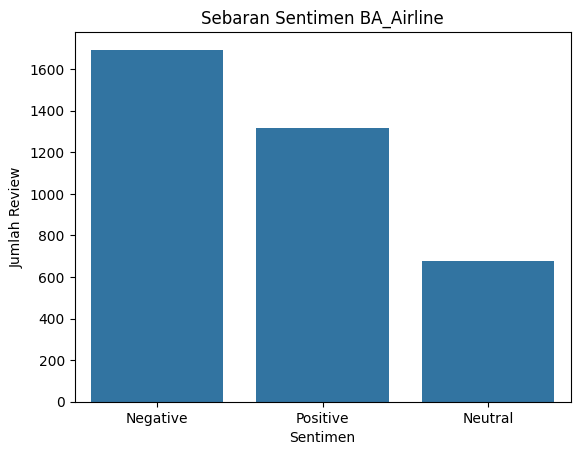

Sentiment
Negative    1693
Positive    1318
Neutral      675
Name: count, dtype: int64


In [18]:
sns.countplot(x='Sentiment', data=df_airline)
plt.title('Sebaran Sentimen BA_Airline')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Review')
plt.show()
sentiment_counts = df_airline['Sentiment'].value_counts()
print(sentiment_counts)

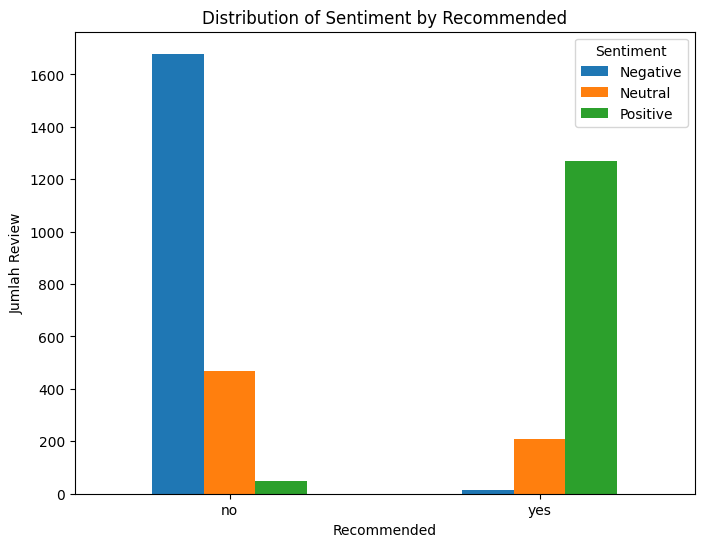

Sentiment    Negative  Neutral  Positive
Recommended                             
no               1679      467        48
yes                14      208      1270


In [19]:
pivot_table = df_airline.pivot_table(
    index='Recommended',
    columns='Sentiment',
    aggfunc='size',
    fill_value=0
)

pivot_table.plot(kind='bar', figsize=(8,6))
plt.title('Distribution of Sentiment by Recommended')
plt.xlabel('Recommended')
plt.ylabel('Jumlah Review')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.show()
sentiment_each_recommended = pd.crosstab(df_airline['Recommended'], df_airline['Sentiment'])
print(sentiment_each_recommended)

Pre-Trained

In [20]:
label2id = {"Negative": 0, "Neutral": 1, "Positive": 2}
id2label = {v: k for k, v in label2id.items()}
df_airline['label'] = df_airline['Sentiment'].map(label2id)

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["ReviewText"], truncation=True, padding="max_length", max_length=500)

keep_cols = ["input_ids", "attention_mask", "label"]
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=preds, references=labels, average="weighted")["precision"],
        "recall": recall_metric.compute(predictions=preds, references=labels, average="weighted")["recall"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_metrics_list = []
fold_models = []

for fold, (train_idx, test_idx) in enumerate(kf.split(df_airline)):
    print(f"\n=== Training fold {fold + 1}/{k} ===")

    train_fold = df_airline.iloc[train_idx]
    test_fold = df_airline.iloc[test_idx]

    train_ds = Dataset.from_pandas(train_fold).map(tokenize, batched=True)
    test_ds = Dataset.from_pandas(test_fold).map(tokenize, batched=True)

    train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in keep_cols])
    test_ds = test_ds.remove_columns([c for c in test_ds.column_names if c not in keep_cols])

    model = RobertaForSequenceClassification.from_pretrained(
        "roberta-base",
        num_labels=3,
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir=f"./roberta-airline-fold{fold+1}",
        eval_strategy="epoch",
        save_strategy="no",
        learning_rate=2e-5,
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        weight_decay=0.01,
        logging_steps=100,
        load_best_model_at_end=False,
        fp16=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        compute_metrics=compute_metrics
    )

    trainer.train()

    preds = trainer.predict(test_ds)
    pred_labels = preds.predictions.argmax(-1)
    metrics = compute_metrics((preds.predictions, test_fold['label'].values))

    fold_metrics_list.append(metrics)
    fold_models.append(model)

    print(f"Fold {fold+1} metrics: {metrics}")

best_fold_idx = np.argmax([m["f1"] for m in fold_metrics_list])
best_metrics = fold_metrics_list[best_fold_idx]

print(f"\nBest fold: {best_fold_idx + 1} with metrics: {best_metrics}")

best_model = fold_models[best_fold_idx]

best_model.save_pretrained("airline-sentiment-model")
tokenizer.save_pretrained("airline-sentiment-model")

full_ds = Dataset.from_pandas(df_airline).map(tokenize, batched=True)
full_ds = full_ds.remove_columns([c for c in full_ds.column_names if c not in keep_cols])

predict_args = TrainingArguments(
    output_dir="./roberta-best-fold",
    eval_strategy="no",
    per_device_eval_batch_size=16,
    fp16=True
)

trainer_best = Trainer(
    model=best_model,
    args=predict_args
)

preds_full = trainer_best.predict(full_ds)
pred_labels_full = preds_full.predictions.argmax(-1)

df_airline['Sentiment'] = [id2label[i] for i in pred_labels_full]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]


=== Training fold 1/5 ===


Map:   0%|          | 0/2948 [00:00<?, ? examples/s]

Map:   0%|          | 0/738 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chayatun2901 (chayatun2901-its) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.703700,0.505131,0.802168,0.778314,0.802168,0.780997
2,0.428500,0.474780,0.807588,0.801761,0.807588,0.802818
3,0.330500,0.519205,0.794038,0.791583,0.794038,0.792448


Fold 1 metrics: {'accuracy': 0.7940379403794038, 'precision': 0.7915829345984557, 'recall': 0.7940379403794038, 'f1': 0.7924484688473387}

=== Training fold 2/5 ===


Map:   0%|          | 0/2949 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.726100,0.581419,0.755767,0.725514,0.755767,0.717048
2,0.436200,0.504429,0.797829,0.782434,0.797829,0.780546
3,0.333800,0.505108,0.830393,0.818330,0.830393,0.821606


Fold 2 metrics: {'accuracy': 0.830393487109905, 'precision': 0.8183303861271771, 'recall': 0.830393487109905, 'f1': 0.821606117356997}

=== Training fold 3/5 ===


Map:   0%|          | 0/2949 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.775200,0.493603,0.805970,0.771465,0.805970,0.778188
2,0.440600,0.477069,0.800543,0.799033,0.800543,0.799576
3,0.351500,0.518625,0.811398,0.803992,0.811398,0.807301


Fold 3 metrics: {'accuracy': 0.8113975576662144, 'precision': 0.8039917896227661, 'recall': 0.8113975576662144, 'f1': 0.8073012141394611}

=== Training fold 4/5 ===


Map:   0%|          | 0/2949 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.710000,0.506464,0.801900,0.805825,0.801900,0.802926
2,0.423000,0.457214,0.823609,0.816590,0.823609,0.818389
3,0.323100,0.490066,0.822252,0.811531,0.822252,0.815933


Fold 4 metrics: {'accuracy': 0.8222523744911805, 'precision': 0.8115309069205643, 'recall': 0.8222523744911805, 'f1': 0.8159328041516992}

=== Training fold 5/5 ===


Map:   0%|          | 0/2949 [00:00<?, ? examples/s]

Map:   0%|          | 0/737 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.734000,0.754102,0.715061,0.693561,0.715061,0.673991
2,0.455100,0.453717,0.827680,0.822991,0.827680,0.824491
3,0.345000,0.490847,0.823609,0.816053,0.823609,0.818780


Fold 5 metrics: {'accuracy': 0.8236092265943012, 'precision': 0.8160527225958583, 'recall': 0.8236092265943012, 'f1': 0.8187798486305948}

Best fold: 2 with metrics: {'accuracy': 0.830393487109905, 'precision': 0.8183303861271771, 'recall': 0.830393487109905, 'f1': 0.821606117356997}


Map:   0%|          | 0/3686 [00:00<?, ? examples/s]

In [21]:
if "label" in df_airline.columns:
    df_airline = df_airline.drop(columns=["label"])
df_airline.head()

,OverallRating,Name,Datetime,VerifiedReview,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity,Sentiment,ReviewText
0,1.0,L Keele,19th November 2023,True,Couple Leisure,Economy Class,London to Stuttgart,November 2023,1.0,1.0,1.0,1.0,no,UnknownAircraft,-1.0,-1.0,-1.0,Negative,"""Service level far worse then Ryanair"" 4 Hours..."
1,3.0,Austin Jones,19th November 2023,True,Business,Economy Class,Brussels to London,November 2023,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0,Negative,"""do not upgrade members based on status"" I rec..."
2,8.0,M A Collie,16th November 2023,False,Couple Leisure,Business Class,London Heathrow to Dublin,November 2023,3.0,3.0,4.0,3.0,yes,A320,4.0,-1.0,-1.0,Positive,"""Flight was smooth and quick"" Boarded on time,..."
3,1.0,Nigel Dean,16th November 2023,True,Couple Leisure,Economy Class,London to Dublin,December 2022,3.0,3.0,1.0,1.0,no,UnknownAircraft,-1.0,-1.0,-1.0,Negative,"""Absolutely hopeless airline"" 5 days before th..."
4,1.0,Gaylynne Simpson,14th November 2023,False,Couple Leisure,Economy Class,London to Lisbon,November 2023,1.0,1.0,1.0,1.0,no,UnknownAircraft,1.0,1.0,1.0,Negative,"""Customer Service is non existent"" We traveled..."


In [22]:
df_airline.to_csv("BA_AirlineReviews_WITH_SENTIMENT.csv", index=False)

Exploratory Data Analys

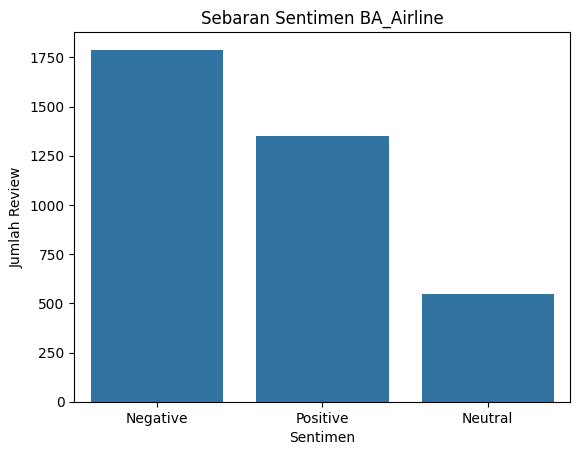

Sentiment
Negative    1789
Positive    1349
Neutral      548
Name: count, dtype: int64


In [23]:
sns.countplot(x='Sentiment', data=df_airline)
plt.title('Sebaran Sentimen BA_Airline')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Review')
plt.show()
sentiment_counts = df_airline['Sentiment'].value_counts()
print(sentiment_counts)

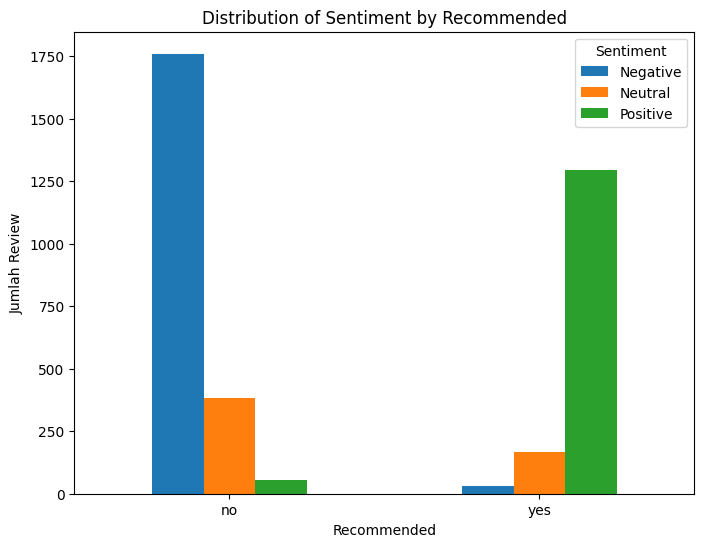

Sentiment    Negative  Neutral  Positive
Recommended                             
no               1760      381        53
yes                29      167      1296


In [24]:
pivot_table = df_airline.pivot_table(
    index='Recommended',
    columns='Sentiment',
    aggfunc='size',
    fill_value=0
)

pivot_table.plot(kind='bar', figsize=(8,6))
plt.title('Distribution of Sentiment by Recommended')
plt.xlabel('Recommended')
plt.ylabel('Jumlah Review')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.show()
sentiment_each_recommended = pd.crosstab(df_airline['Recommended'], df_airline['Sentiment'])
print(sentiment_each_recommended)

Graph Database

In [25]:
ip="44.204.255.88"
port="7687"
pwd="thunder-relief-classification"
graph = Graph("bolt://"+ip+":"+port, auth=("neo4j", pwd))

In [26]:
def run_request(cypher_query, graph_obj):
    graph_obj.run(cypher_query)

In [27]:
cypher_query = """
    MERGE (p:Passenger {name: $name})
    MERGE (route:Route {name: $route})
    MERGE (ac:Aircraft {model: $aircraft})
    MERGE (st:SeatType {class: $seat_type})
    MERGE (tt:TravellerType {type: $traveller_type})

    CREATE (r:Review {
        date: $datetime,
        text: $review_text,
        verified: $verified,
        recommended: $recommended,
        date_flown: $date_flown,

        overall_rating: toFloat($overall_rating),
        seat_comfort: toFloat($seat_comfort),
        cabin_staff: toFloat($cabin_staff),
        ground_service: toFloat($ground_service),
        value_money: toFloat($value_money),
        food: toFloat($food),
        entertainment: toFloat($entertainment),
        wifi: toFloat($wifi)
    })

    MERGE (p)-[:WROTE]->(r)
    MERGE (r)-[:ABOUT_FLIGHT]->(route)
    MERGE (r)-[:FLOWN_ON]->(ac)
    MERGE (r)-[:IN_SEAT]->(st)
    MERGE (r)-[:TRAVELLED_AS]->(tt)

    MERGE (s:Sentiment {label: $sentiment})
    MERGE (r)-[:HAS_SENTIMENT]->(s)
"""

In [28]:
tx = graph.begin()

print("Sedang memproses data...")
for index, row in df_airline.iterrows():
    params = {
        "name": row["Name"],
        "route": row["Route"],
        "aircraft": row["Aircraft"],
        "seat_type": row["SeatType"],
        "traveller_type": row["TypeOfTraveller"],
        "datetime": row["Datetime"],
        "review_text": row["ReviewText"],
        "verified": bool(row["VerifiedReview"]),
        "recommended": row["Recommended"],
        "date_flown": row["DateFlown"],
        "overall_rating": row["OverallRating"],
        "seat_comfort": row["SeatComfort"],
        "cabin_staff": row["CabinStaffService"],
        "ground_service": row["GroundService"],
        "value_money": row["ValueForMoney"],
        "food": row["Food&Beverages"],
        "entertainment": row["InflightEntertainment"],
        "wifi": row["Wifi&Connectivity"],
        "sentiment": row["Sentiment"]
    }

    tx.run(cypher_query, params)

    if index > 0 and index % 500 == 0:
        tx.commit()
        tx = graph.begin()
        print(f"{index} data terproses...")

tx.commit()
print("Selesai!.")

Sedang memproses data...


/tmp/ipython-input-884231640.py:30: DeprecationWarning: The transaction.commit() method is deprecated, use graph.commit(transaction) instead
  tx.commit()


500 data terproses...
1000 data terproses...
1500 data terproses...
2000 data terproses...
2500 data terproses...
3000 data terproses...
3500 data terproses...
Selesai!.


/tmp/ipython-input-884231640.py:34: DeprecationWarning: The transaction.commit() method is deprecated, use graph.commit(transaction) instead
  tx.commit()


In [ ]:
!zip -r airline-sentiment-model.zip airline-sentiment-model

  adding: airline-sentiment-model/ (stored 0%)
  adding: airline-sentiment-model/model.safetensors (deflated 12%)
  adding: airline-sentiment-model/config.json (deflated 52%)
  adding: airline-sentiment-model/special_tokens_map.json (deflated 84%)
  adding: airline-sentiment-model/tokenizer_config.json (deflated 76%)
  adding: airline-sentiment-model/vocab.json (deflated 68%)
  adding: airline-sentiment-model/merges.txt (deflated 53%)


In [ ]:
!cp airline-sentiment-model.zip /content/drive/MyDrive/